# Pipeline Configuration Benchmarking 

In [1]:
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from src.dataset import SegmentationDataset
from src.data_utils import plot_sample_batch
from src.data_pipeline import SegmentationDataPipeline


%load_ext lab_black
%load_ext autoreload
%autoreload 2

2022-11-10 14:56:03.722625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/hadoop/lib/native
2022-11-10 14:56:03.722768: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-10 14:56:03.834038: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 14:56:06.754549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/hadoop/lib/native
2022-11-10 14:56:06.755635: W tensorflow

### Initialize Dataset

In [10]:
IMG_SHAPE = (256, 1600)
ANNOTATIONS_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../data/train_images/"

# instantiate dataset
sd = SegmentationDataset(
    label_file=ANNOTATIONS_PATH,
    img_dir_path=TRAIN_IMG_PATH,
    img_shape=IMG_SHAPE,
    test_size=0.1,
)

In [23]:
sd._build_class_weight_map("ens")

{-2: 1.6104, 3: 0.4018, 4: 0.9878}

In [26]:
sd._build_class_weight_map("ens", 0.99)

{-2: 1.038, 3: 0.9782, 4: 0.9837}

In [27]:
sd._build_class_weight_map("ens", 0.999)

{-2: 1.6104, 3: 0.4018, 4: 0.9878}

In [28]:
sd._build_class_weight_map("ens", 0.9999)

{-2: 1.8397, 3: 0.136, 4: 1.0243}

In [24]:
sd._build_class_weight_map("ip")

{-2: 6.5246, 3: 0.3894, 4: 3.5911}

In [29]:
"kfdja".upper()

'KFDJA'

### Pipeline with inline preprocessing

In [5]:
# create train/test & x/y splits
train_imgs, test_imgs = sd.get_train_test_split(test_size=0.1)
X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="inline")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="inline")

In [7]:
# instantiate dataset
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="inline",
    pipeline_options={
        "map_parallel": None,  # off if None
        "cache": False,
        "shuffle_buffer_size": False,  # off if False
        "batch_size": 8,
        "prefetch": False,  # off if False
    },
)

# create dataset pipelines
train_dataset_inline = sdp(X_train, y_train)

2022-11-09 14:54:16.790344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/hadoop/lib/native
2022-11-09 14:54:16.790553: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-09 14:54:16.790689: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (byv94trivcgkc60v): /proc/driver/nvidia/version does not exist


AUGMENTING!!
Batching


In [8]:
sample_inline = list(train_dataset_inline.take(1).as_numpy_iterator())

In [9]:
sample_inline[0][0].shape, sample_inline[0][1].shape

((8, 256, 1600, 3), (8, 256, 1600, 3))

In [10]:
sample_inline[0][0].shape

(8, 256, 1600, 3)

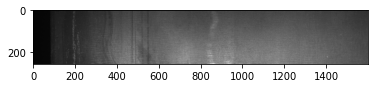

In [11]:
plt.imshow(sample_inline[0][0][1])

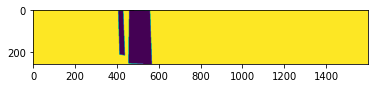

In [13]:
plt.imshow(np.expand_dims(sample_inline[0][1][1][..., 0], axis=-1))

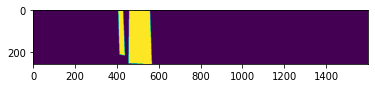

In [12]:
plt.imshow(np.expand_dims(sample_inline[0][1][1][..., 1], axis=-1))

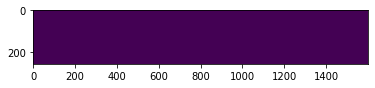

In [14]:
plt.imshow(np.expand_dims(sample_inline[0][1][1][..., 2], axis=-1))

### Pipeline with preemptive preprocessing

In [11]:
# create train/test & x/y splits
train_imgs, test_imgs = sd.get_train_test_split(test_size=0.1)

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
train_sample_weights = sd.get_sample_weight_sequence(train_imgs)


X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

In [12]:
# instantiate dataset
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,  # off if None
        "cache": False,
        "shuffle_buffer_size": False,  # off if False
        "batch_size": 8,
        "prefetch": False,  # off if False
    },
)

# create dataset pipelines
train_dataset_pp = sdp(X_train, y_train, is_train=True)
test_dataset_pp = sdp(X_test, y_test, is_train=False)

AUGMENTING!!
Batching
Batching


In [13]:
train_dataset_pp = sdp(
    X_train, y_train, is_train=True, sample_weights=train_sample_weights
)
test_dataset_pp = sdp(X_test, y_test, is_train=False)

AUGMENTING!!
Batching
Batching


In [21]:
# train_dataset_pp = sdp(X_train, y_train, is_train=True)
sample_pp = list(train_dataset_pp.take(1).as_numpy_iterator())
sample_pp[0][0].shape, sample_pp[0][1].shape, sample_pp[0][2].shape

((8, 256, 1600, 3), (8, 256, 1600, 3), (8,))

In [22]:
sd.class_weight_map

{-2: 1.038, 3: 0.9782, 4: 0.9837}

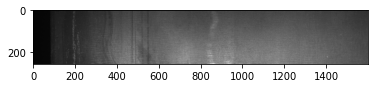

In [19]:
plt.imshow(sample_pp[0][0][1])

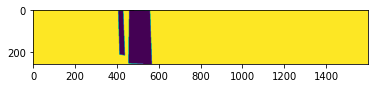

In [21]:
plt.imshow(np.expand_dims(sample_pp[0][1][1][..., 0], axis=-1))

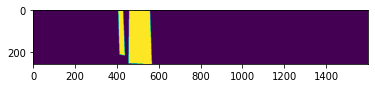

In [20]:
plt.imshow(np.expand_dims(sample_pp[0][1][1][..., 1], axis=-1))

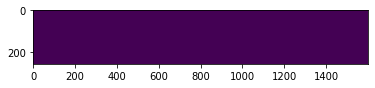

In [22]:
plt.imshow(np.expand_dims(sample_pp[0][1][1][..., 2], axis=-1))

### Plot a batch


In [145]:
plot_sample_batch(sample_pp)

TypeError: plot_sample_batch() missing 2 required positional arguments: 'y_true' and 'y_pred'

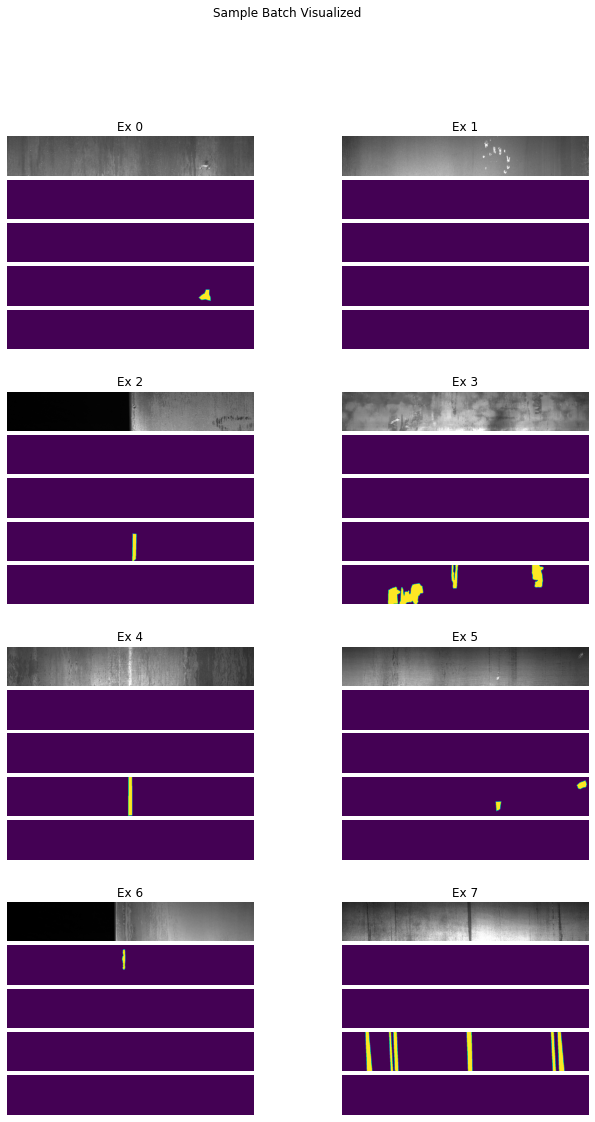

In [12]:
plot_sample_batch(sample_inline)

## Benchmarking (TO DO)

## `tf.data` pipeline

Benchmark the following scenarios:

0. Impact of cache, batch, prefetch?
1. Masks are RLE encoded in csv file (i.e. tf.data pipeline has to transform into Tensors)
2. Masks and images are pre-saved as Tensors (i.e. all image masks are converted to tf.records prior)
3. Masks/images are loaded using `keras.utils.Sequence` (ex. https://keras.io/examples/vision/oxford_pets_image_segmentation/)
4. ImageDataGenerator in keras...
5. Using np_func / py_func for RLE decoding vs. raw TensorFlow functions

In [16]:
def benchmark_dataloading(dataset, n_epochs):
    start = time.time()
    for epoch in range(n_epochs):
        for i, sample in enumerate(dataset):
            time.sleep(0.01)  # imitate train step
            pass
    end = time.time()
    print("Execution time:", end - start)

In [17]:
# batch only
benchmark_dataloading(train_dataset, 1)

Execution time: 310.7924337387085


In [8]:
# batch only
benchmark_dataloading(train_dataset, 5)

Execution time: 11.809537172317505


In [13]:
# cache and batch
benchmark_dataloading(train_dataset, 5)

Execution time: 3.296800374984741


In [16]:
# batch, cache, prefetch
benchmark_dataloading(train_dataset, 5)

Execution time: 3.540153741836548
